# Org, Jupyter Compatibility

First, activate the environment that has a jupyter installation. Then
load the `emacs/jupyter` package.

``` commonlisp
(myPython/activate-conda-env "~/.opt/miniconda3/envs/nielit-project")
```

This can be used to convert the `org` file into a `ipynb` file.

``` shell
pandoc game_recommender.org -o game_recommender.ipynb
```

# Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# The Report

## The Problem Statement

> Given a list of games previously played by a user, recommend new
> games.

## The Data Set

The dataset was obtained from
[Kaggle](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam?select=games.csv).
It comprises of 4 files,

games.csv  
A record of games. Here, we are mainly interested in the title, ratings,
and the final price.

games_metadata.json  
Provides the tags/genres for the games. This can be used to find
similarities between games.

users.csv  
A list of users, the number of games they bought, and the number of
times they reviewed anything. The number of games bought can be used to
filter out a number of users from being considered.

recommendations.csv  
List of user reviews, in a form that answers if said user recommends a
certain game or not.

## Data Cleaning

It is worth noting that these files, `users` and `recommendations` in
particular, are much too large. Quite a few fields are of no use to us.

### Game Metadata

The original metadata file was badly formatted (set of top-level
objects), so we use `jq` to fix it. Additionally, we drop the game
description.

``` shell
jq -s 'del(.[].description)' games_metadata.json > games_metadata_slurp.json
printf "%s Entries" $(jq '.[].app_id' games_metadata_slurp.json| wc -l)
```

From here, filter out the games that have no tags listed, since these
won't really help in the classification.

``` shell
jq '.[] | select(.tags | length > 0)' games_metadata_slurp.json| jq -s > games_metadata_processed.json
printf "%s Entries" $(jq '.[].app_id' games_metadata_processed.json| wc -l)
```

We remove a few of these entries,

In [ ]:
with open("games_metadata_processed.json") as source:
    games_metadata = json.load(source)

def get_reduced_games_metadata(games_metadata):
    LIMIT = 30000
    return games_metadata[:LIMIT]

games_metadata = get_reduced_games_metadata(games_metadata)


Then save these to disk.

In [ ]:
with open("games_metadata_processed.json", "w") as sink:
    json.dump(games_metadata, sink)


### Games

In [3]:
games = pd.read_csv("games.csv")
games.head()


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


We are not concerned with the release dates, discounts or the original
prices, only the final price of the game; we can safely drop the
corresponding fields. We also have no use for the user review count here
(will rely on the `recommendations` dataset) or the positive ratio (the
rating sentament value suffices).

In [4]:
games = games.drop(["date_release", "price_original", "discount", "user_reviews", "positive_ratio"], axis=1)


It's pobably a lot more efficient to just target a single platform, so
let's choose the one with the largest number of games compatible.

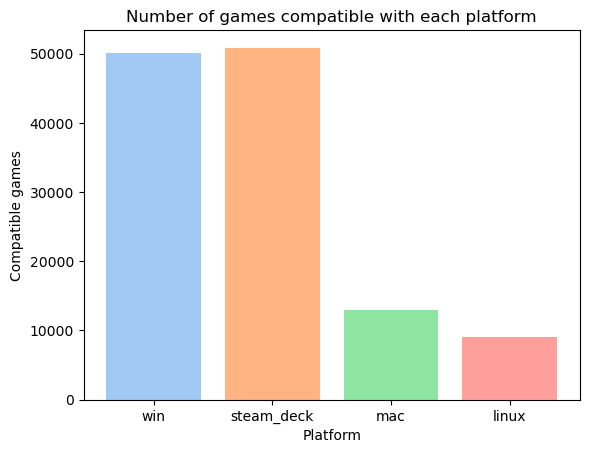

In [5]:
def plot_games_in_platform():
    platforms: list[str] = ["win", "steam_deck", "mac", "linux"]
    games_in_platform = games[platforms].sum()
    plt.bar(games_in_platform.keys(), games_in_platform, color=sns.color_palette("pastel"))
    plt.title("Number of games compatible with each platform")
    plt.xlabel("Platform")
    plt.ylabel("Compatible games")
    plt.show()

plot_games_in_platform()


We note that the Stem Deck has the best compatibility, so, for
simplicity's sake we assume that every user owns one, and we can drop
the other 3.

In [6]:
games = games.drop(["win", "linux", "mac"], axis=1)


We also drop the games that are not compatible with the Steam Deck.

In [7]:
games["steam_deck"] = games["steam_deck"].replace(False, np.nan)
games = games.dropna(subset=["steam_deck"])

# We are done with the filtering, so this column too is unneeded
games = games.drop(["steam_deck"], axis=1)


Then we remove the games we filtered out in the games metadata dataset.

In [8]:
games_metadata = pd.read_json("games_metadata_processed.json")

games = games[
    games["app_id"].isin(games_metadata["app_id"])
]

print(f"{games.shape[0]} Entries")


30000 Entries


Finally, we write this file to disk for future use.

In [ ]:
games.to_csv("games_processed.csv", index=False)


### Users

In [11]:
users = pd.read_csv("users.csv")
users


,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


Inspecting the dataset, a number of users never bought any products,

In [12]:
users["products"] = users["products"].replace(0, np.nan)
users["products"].isna().sum()


np.int64(139318)

We can ignore them since they do not help in making any predictions.

In [13]:
users = users.dropna(subset=["products"])
print(f"{users.shape[0]} rows")


14166746 rows


This is still a very large dataset, and needs to be reduced.

Using a scatterplot

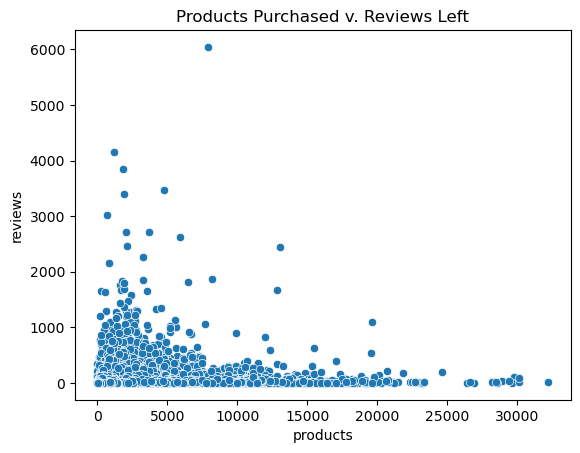

In [14]:
sns.scatterplot(users, x="products", y="reviews")
plt.title("Products Purchased v. Reviews Left")
plt.show()


We note that users who left the largest number of reviews bought
somewhere under 10,000 games.

We consider only a handful of users, preferring those who left a large
number of reviews.

In [15]:
def get_reduced_users(users):
    users_sorted_by_reviews = users.sort_values("reviews", ascending=False)
    LIMIT = 40000
    return users_sorted_by_reviews.head(LIMIT)

users = get_reduced_users(users)


Finally, we write the dataset into a new file,

In [ ]:
users.to_csv("users_processed.csv", index=False)


### Recommendations

In [16]:
recommendations = pd.read_csv("recommendations.csv", index_col="review_id")
recommendations


,app_id,helpful,funny,date,is_recommended,hours,user_id
review_id,,,,,,,
0,975370,0,0,2022-12-12,True,36.3,51580
1,304390,4,0,2017-02-17,False,11.5,2586
2,1085660,2,0,2019-11-17,True,336.5,253880
3,703080,0,0,2022-09-23,True,27.4,259432
4,526870,0,0,2021-01-10,True,7.9,23869
...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41.0,1606890
41154790,758870,8,0,2019-07-18,False,8.0,1786254
41154791,696170,3,10,2018-03-26,False,2.0,6370324


The `funny` and `date` columns do not provide any useful information, so
we drop them. We also drop the `helpful` column since we are only
interested in user similarities.

In [17]:
recommendations = recommendations.drop(["funny", "date", "helpful"], axis=1)


We limit this dataset to contain only those games and users that we
selected.

In [18]:
recommendations = recommendations[
    recommendations["app_id"].isin(games["app_id"])
    & recommendations["user_id"].isin(users["user_id"])
]

print(f"{recommendations.shape[0]} Entries")


1771884 Entries


Since the games and users were filtered out indepedant of each other, we
can not say for sure that each user left as many reviews as reported in
the users dataset. So, we drop off the users with a low review count.

In [19]:
recommendations = recommendations.groupby("user_id").filter(lambda x: len(x) > 50)

print(f"{recommendations.shape[0]} Entries")


919920 Entries


*The `users` dataset will not be used further, so no point in updating
it.* *The `games` dataset will be used for content based filtering, and
can be used independant of the recommendations dataset*

Saving this file,

In [ ]:
recommendations.to_csv("recommendations_processed.csv", index=False)


## The Model

First, we make sure we are using the newly processed datasets.

In [34]:
games = pd.read_csv("games_processed.csv")

with open("games_metadata_processed.json") as source:
    games_metadata = pd.read_json(source)

recommendations = pd.read_csv("recommendations_processed.csv")


Now, the following data is available to us:

In [22]:
print(f"Games: {list(games.keys())}")
print(f"GamesMetadata: {list(games_metadata.keys())}")
print(f"Recommendations: {list(recommendations.keys())}")


Games: ['app_id', 'title', 'rating', 'price_final']
GamesMetadata: ['app_id', 'tags']
Recommendations: ['app_id', 'is_recommended', 'hours', 'user_id']


The idea is to use the features of the games played by a user to test if
they'd like an arbitrary game they haven't yet played. This is
equivalent to classifying a new game into one of ("will like", "won't
like"). The features we shall use are

- Overall rating of the game (as it appears on the `steam` store)
- The price
- The games' genres/tags (this makes use of the `is_recommended` feature
  from the `recommendations` dataset to select the tags preferred by the
  user)

### Some More Processing

1.  Grouping the Game Prices

    We shall group the game prices into

    1.  Free
    2.  Budget :: if its under \$50
    3.  Expensive

In [23]:
def classify_price(price: float) -> int:
    return (
        0 if price == 0
        else 1 if price < 50
        else 2
    )

After classifying the prices, we can drop the original `price_final`
feature.

In [42]:
games = games.assign(
    price_category=games["price_final"].apply(classify_price)
)

games = games.drop("price_final", axis=1)

2.  Encode the Overall Rating

In [43]:
games["rating_encoded"] = LabelEncoder().fit_transform(games["rating"])
games = games.drop("rating", axis=1)

3.  Unpacking the Genre information

It would be hard to compare genre lists, so we unpack them into
binary columns of their own.

In [35]:
games_metadata["tags"] = games_metadata["tags"].apply(
    lambda tags: tags if isinstance(tags, list) else []
)
all_tags = set(tag for tags in games_metadata["tags"] for tag in tags)

f"{len(all_tags)} tags in total"

'440 tags in total'

Now, there are a lot of tags, so we keep only the more commonly
recurring ones,

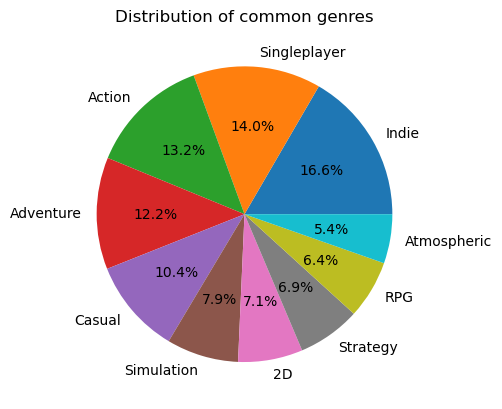

In [37]:
def plot_genre_distribution():
    THRESHOLD = 5000
    tags = games_metadata["tags"].explode()
    tag_counts = tags.value_counts()
    valid_tags = tag_counts[tag_counts >= THRESHOLD].keys()
    tags = tags[tags.isin(valid_tags)].value_counts()
    tags.plot.pie(autopct="%1.1f%%")
    plt.title("Distribution of common genres")
    plt.ylabel('')
    plt.show()

plot_genre_distribution()

In [39]:
def get_reduced_tags(all_tags):
    MIN = 2000
    tag_counts = games_metadata["tags"].explode().value_counts()
    return set(tag for tag in all_tags
               if tag in tag_counts[tag_counts > MIN].keys())

all_tags = get_reduced_tags(all_tags)
f"{len(all_tags)} tags"

'40 tags'

In [40]:
for tag in all_tags:
    games_metadata[tag] = games_metadata["tags"].apply(lambda tags: int(tag in tags))

games_metadata = games_metadata.drop("tags", axis=1)

### Merging the Datasets

In [44]:
games_unified = games.merge(games_metadata, how="left", on="app_id")
df = recommendations.merge(games_unified, how="left", on="app_id")


,app_id,is_recommended,hours,user_id,title,price_category,rating_encoded,Retro,RPG,Casual,...,Action,Pixel Graphics,Puzzle,Strategy,Exploration,Horror,Arcade,Relaxing,Funny,Cute
0,1325200,True,94.5,11593837,Nioh 2 – The Complete Edition,1,8,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,1544020,False,3.8,9650854,The Callisto Protocol™,2,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,678950,True,252.1,12064518,DRAGON BALL FighterZ,2,8,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,1325200,True,11.8,4731740,Nioh 2 – The Complete Edition,1,8,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,678950,True,3.2,8644825,DRAGON BALL FighterZ,2,8,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919915,333600,True,9.0,4802239,NEKOPARA Vol. 1,1,5,0,0,1,...,0,0,0,0,0,0,0,0,1,1
919916,6910,False,1.0,11783959,Deus Ex: Game of the Year Edition,1,8,0,1,0,...,1,0,0,0,0,0,0,0,0,0
919917,1138660,True,31.0,11425154,Black Book,1,8,0,1,0,...,0,0,0,1,0,0,0,0,0,0
919918,1818450,True,1.0,13261742,STALCRAFT,0,2,0,1,0,...,1,0,0,0,0,1,0,0,0,0


### Training and Testing

Now that we have a single unified dataset, we can use it for training
our model. The `app_id` provides us no more information than the game
tags, rating and price, so we drop it, along with some other *useless*
information.

In [31]:
X = df.drop(["app_id", "title", "is_recommended", "hours"], axis=1)
y = df["is_recommended"]

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


We then evaluate the model using it's precision, recall, and F1 scores.

In [32]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.32      0.29      0.30    160779
        True       0.81      0.82      0.81    575157

    accuracy                           0.71    735936
   macro avg       0.56      0.56      0.56    735936
weighted avg       0.70      0.71      0.70    735936



This model performs very poorly at answering if the user would dislike a
game.  
Our purpose for this model is, however, to recommend games that
the user **might** like, which it does fairly well.